In [1]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision

import argparse
import sys
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime 
import csv
import configparser
import argparse
import platform

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle


In [2]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1050
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 5000
        _num2           = 1000
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)
        
        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.ReLU(True))
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        self._initialize_weight()        
    
    def _initialize_weight(self) :
        for m in self.modules() :
            n = m.in_features
            m.weight.data.uniform_(-1.0 / math.sqrt(n), 1.0/math.sqrt(n))
            if m.bias is not None :
                m.bias.data.zero_()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x
    '''
    def forward(self, x) :
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    '''
    def modules(self) :
        return [self.fc1,self.fc2,self.fc3]

In [4]:

# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

train_data_path = '../data/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
loader_train = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=3)  


validation_data_path = '../data/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
loader_test = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=False, num_workers=3)  



num_classes = 2

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

model = Linear(num_classes=num_classes)



In [5]:

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 1

if bCuda:
 
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

learning_rate = 0.0005

# weight decay applyed
optimizer   = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 0.00001 )
objective   = nn.CrossEntropyLoss()




In [6]:

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------


def train():

    # print('train the model at given epoch')

    loss_train = []

    accuracy_train   = []
    correct          = 0


    
    
    model.train()

    for idx_batch, (data, target) in enumerate(loader_train):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()

        output  = model(data)
        loss    = objective(output, target)

        # train acc
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        accuracy_train.append(correct / len(data))
        ##
        
        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        
              
        
    loss_train_epoch     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)
    accuracy_train_std = np.std(accuracy_train)
    accuracy_train_epoch   = 100. * float(correct) / len(loader_train.dataset)
    return {'loss_train_epoch': loss_train_epoch, 'loss_train_std': loss_train_std, 'accuracy_train_epoch' : accuracy_train_epoch, 'accuracy_train_std' : accuracy_train_std}



In [7]:

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(loader_test.dataset)
    accuracy_test   = 100. * float(correct) / len(loader_test.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------

# for system not down
epoch_limit = 60000
loss_train_epoch = {}
loss_train_std = {}
accuracy_train_std = {}
accuracy_train_epoch = {}
loss_test = {}
accuracy_test = {}
epoch_list = []
loss_conv = 0.000001
conv_count = 0

for e in range(epoch_limit):
        
    result_train    = train()
    result_test     = test()

    loss_train_epoch[e]  = result_train['loss_train_epoch']
    loss_train_std[e]   = result_train['loss_train_std']
    accuracy_train_epoch[e]   = result_train['accuracy_train_epoch']
    accuracy_train_std[e] = result_train['accuracy_train_std']

    loss_test[e]        = result_test['loss_test']
    accuracy_test[e]    = result_test['accuracy_test']
    
    print("epoch : %3s| loss : (train) %10.10s (testing) %10.10s | accuracy : (train) %10.10s (testing) %10.10s"%(e,loss_train_epoch[e],loss_test[e],accuracy_train_epoch[e],accuracy_test[e]))
    epoch_list.append(e)
    
    if (e > 0) :   
        if (abs(loss_train_epoch[e]-loss_train_epoch[e-1]) < loss_conv ) :
            conv_count += 1
            if (conv_count > 1) :
                print("loss is converged")
                break
        else :
            conv_count = 0
    

epoch :   0| loss : (train) 0.00860963 (testing) 0.00797729 | accuracy : (train) 54.0408958 (testing)  52.734375
epoch :   1| loss : (train) 0.00854068 (testing) 0.00791385 | accuracy : (train) 55.3067185 (testing)    51.5625
epoch :   2| loss : (train) 0.00850175 (testing) 0.00786009 | accuracy : (train) 54.3330087 (testing)       50.0
epoch :   3| loss : (train) 0.00853291 (testing) 0.00781809 | accuracy : (train) 52.9698149 (testing)       50.0
epoch :   4| loss : (train) 0.00843607 (testing) 0.00777336 | accuracy : (train) 53.2619279 (testing)       50.0
epoch :   5| loss : (train) 0.00843958 (testing) 0.00773624 | accuracy : (train) 53.0671859 (testing)       50.0
epoch :   6| loss : (train) 0.00842845 (testing) 0.00770167 | accuracy : (train) 52.8724440 (testing)       50.0
epoch :   7| loss : (train) 0.00845865 (testing) 0.00767236 | accuracy : (train) 53.8461538 (testing)  50.390625
epoch :   8| loss : (train) 0.00840421 (testing) 0.00763865 | accuracy : (train) 54.4303797 (tes

epoch :  73| loss : (train) 0.00758884 (testing) 0.00611415 | accuracy : (train) 74.0019474 (testing)  86.328125
epoch :  74| loss : (train) 0.00739481 (testing) 0.00609453 | accuracy : (train) 74.1966893 (testing)  85.546875
epoch :  75| loss : (train) 0.00735205 (testing) 0.00607114 | accuracy : (train) 73.3203505 (testing)  86.328125
epoch :  76| loss : (train) 0.00734394 (testing) 0.00605151 | accuracy : (train) 74.1966893 (testing)    85.9375
epoch :  77| loss : (train) 0.00750058 (testing) 0.00603203 | accuracy : (train) 74.0993184 (testing)  85.546875
epoch :  78| loss : (train) 0.00747058 (testing) 0.00602701 | accuracy : (train) 74.1966893 (testing)   86.71875
epoch :  79| loss : (train) 0.00752651 (testing) 0.00599085 | accuracy : (train) 74.7809152 (testing)  85.546875
epoch :  80| loss : (train) 0.00730582 (testing) 0.00597249 | accuracy : (train) 74.0993184 (testing)    85.9375
epoch :  81| loss : (train) 0.00735085 (testing) 0.00595761 | accuracy : (train) 74.3914313 (tes

epoch : 146| loss : (train) 0.00663169 (testing) 0.00473132 | accuracy : (train) 78.1888997 (testing)  88.671875
epoch : 147| loss : (train) 0.00654989 (testing) 0.00471005 | accuracy : (train) 78.2862706 (testing)  88.671875
epoch : 148| loss : (train) 0.00678678 (testing) 0.00473932 | accuracy : (train) 77.7020447 (testing)       87.5
epoch : 149| loss : (train) 0.00662116 (testing) 0.00467789 | accuracy : (train) 78.5783836 (testing)  88.671875
epoch : 150| loss : (train) 0.00670485 (testing) 0.00466708 | accuracy : (train) 78.0915287 (testing)  88.671875
epoch : 151| loss : (train) 0.00665779 (testing) 0.00465107 | accuracy : (train) 78.1888997 (testing)  88.671875
epoch : 152| loss : (train) 0.00666981 (testing) 0.00463678 | accuracy : (train) 78.3836416 (testing)    89.0625
epoch : 153| loss : (train) 0.00634720 (testing) 0.00463466 | accuracy : (train) 77.9941577 (testing)       87.5
epoch : 154| loss : (train) 0.00641564 (testing) 0.00458921 | accuracy : (train) 78.5783836 (tes

epoch : 219| loss : (train) 0.00571580 (testing) 0.00382803 | accuracy : (train) 80.2336903 (testing)   86.71875
epoch : 220| loss : (train) 0.00587462 (testing) 0.00384142 | accuracy : (train) 80.0389483 (testing)  86.328125
epoch : 221| loss : (train) 0.00621919 (testing) 0.00377760 | accuracy : (train) 80.2336903 (testing)  87.890625
epoch : 222| loss : (train) 0.00589882 (testing) 0.00378297 | accuracy : (train) 80.2336903 (testing)  87.109375
epoch : 223| loss : (train) 0.00598662 (testing) 0.00379059 | accuracy : (train) 80.3310613 (testing)   86.71875
epoch : 224| loss : (train) 0.00549971 (testing) 0.00374842 | accuracy : (train) 80.1363193 (testing)  87.890625
epoch : 225| loss : (train) 0.00573201 (testing) 0.00376876 | accuracy : (train) 80.2336903 (testing)   86.71875
epoch : 226| loss : (train) 0.00567930 (testing) 0.00382973 | accuracy : (train) 80.9152872 (testing)  87.109375
epoch : 227| loss : (train) 0.00561013 (testing) 0.00376674 | accuracy : (train) 80.5258033 (tes

epoch : 292| loss : (train) 0.00500479 (testing) 0.00337696 | accuracy : (train) 82.3758519 (testing)  87.109375
epoch : 293| loss : (train) 0.00519363 (testing) 0.00337824 | accuracy : (train) 82.2784810 (testing)  87.109375
epoch : 294| loss : (train) 0.00518286 (testing) 0.00334969 | accuracy : (train) 82.2784810 (testing)   86.71875
epoch : 295| loss : (train) 0.00488781 (testing) 0.00333915 | accuracy : (train) 82.0837390 (testing)   86.71875
epoch : 296| loss : (train) 0.00498800 (testing) 0.00328100 | accuracy : (train) 82.0837390 (testing)  87.109375
epoch : 297| loss : (train) 0.00549691 (testing) 0.00339586 | accuracy : (train) 82.2784810 (testing)       87.5
epoch : 298| loss : (train) 0.00504585 (testing) 0.00340872 | accuracy : (train) 82.5705939 (testing)       87.5
epoch : 299| loss : (train) 0.00511640 (testing) 0.00340809 | accuracy : (train) 82.1811100 (testing)       87.5
epoch : 300| loss : (train) 0.00518154 (testing) 0.00343197 | accuracy : (train) 82.7653359 (tes

epoch : 365| loss : (train) 0.00449750 (testing) 0.00320782 | accuracy : (train) 84.5180136 (testing)       87.5
epoch : 366| loss : (train) 0.00456170 (testing) 0.00315431 | accuracy : (train) 84.6153846 (testing)  87.109375
epoch : 367| loss : (train) 0.00471230 (testing) 0.00313433 | accuracy : (train) 84.7127555 (testing)  87.109375
epoch : 368| loss : (train) 0.00482773 (testing) 0.00316514 | accuracy : (train) 84.6153846 (testing)       87.5
epoch : 369| loss : (train) 0.00496997 (testing) 0.00313334 | accuracy : (train) 84.7127555 (testing)  87.109375
epoch : 370| loss : (train) 0.00462339 (testing) 0.00314388 | accuracy : (train) 84.5180136 (testing)  87.109375
epoch : 371| loss : (train) 0.00463760 (testing) 0.00313797 | accuracy : (train) 84.8101265 (testing)  87.109375
epoch : 372| loss : (train) 0.00464713 (testing) 0.00316925 | accuracy : (train) 84.9074975 (testing)  87.890625
epoch : 373| loss : (train) 0.00419285 (testing) 0.00320036 | accuracy : (train) 85.0048685 (tes

epoch : 438| loss : (train) 0.00373327 (testing) 0.00306347 | accuracy : (train) 86.5628042 (testing)  87.890625
epoch : 439| loss : (train) 0.00416065 (testing) 0.00314587 | accuracy : (train) 86.7575462 (testing)  87.890625
epoch : 440| loss : (train) 0.00428636 (testing) 0.00329975 | accuracy : (train) 87.0496592 (testing)  87.109375
epoch : 441| loss : (train) 0.00408422 (testing) 0.00318464 | accuracy : (train) 86.6601752 (testing)   86.71875
epoch : 442| loss : (train) 0.00401677 (testing) 0.00317360 | accuracy : (train) 86.7575462 (testing)       87.5
epoch : 443| loss : (train) 0.00396258 (testing) 0.00330654 | accuracy : (train) 86.7575462 (testing)  87.109375
epoch : 444| loss : (train) 0.00427308 (testing) 0.00314619 | accuracy : (train) 86.6601752 (testing)  87.890625
epoch : 445| loss : (train) 0.00384037 (testing) 0.00319480 | accuracy : (train) 86.8549172 (testing)   86.71875
epoch : 446| loss : (train) 0.00381821 (testing) 0.00322476 | accuracy : (train) 87.0496592 (tes

epoch : 511| loss : (train) 0.00370435 (testing) 0.00324760 | accuracy : (train) 89.6786757 (testing)   86.71875
epoch : 512| loss : (train) 0.00365560 (testing) 0.00323241 | accuracy : (train) 89.1918208 (testing)  87.109375
epoch : 513| loss : (train) 0.00407295 (testing) 0.00342955 | accuracy : (train) 89.2891918 (testing)       87.5
epoch : 514| loss : (train) 0.00416244 (testing) 0.00340395 | accuracy : (train) 89.4839337 (testing)  87.109375
epoch : 515| loss : (train) 0.00383090 (testing) 0.00339322 | accuracy : (train) 89.2891918 (testing)  87.109375
epoch : 516| loss : (train) 0.00336084 (testing) 0.00323202 | accuracy : (train) 89.6786757 (testing)   86.71875
epoch : 517| loss : (train) 0.00368120 (testing) 0.00321791 | accuracy : (train) 89.6786757 (testing)  86.328125
epoch : 518| loss : (train) 0.00372575 (testing) 0.00342289 | accuracy : (train) 89.4839337 (testing)  87.109375
epoch : 519| loss : (train) 0.00358872 (testing) 0.00334685 | accuracy : (train) 89.6786757 (tes

epoch : 584| loss : (train) 0.00315164 (testing) 0.00344343 | accuracy : (train) 91.4313534 (testing)   86.71875
epoch : 585| loss : (train) 0.00335954 (testing) 0.00334015 | accuracy : (train) 91.4313534 (testing)  87.109375
epoch : 586| loss : (train) 0.00326642 (testing) 0.00347613 | accuracy : (train) 91.5287244 (testing)  87.109375
epoch : 587| loss : (train) 0.00352276 (testing) 0.00345303 | accuracy : (train) 91.6260954 (testing)   86.71875
epoch : 588| loss : (train) 0.00335933 (testing) 0.00347960 | accuracy : (train) 91.3339824 (testing)  87.109375
epoch : 589| loss : (train) 0.00317200 (testing) 0.00350772 | accuracy : (train) 91.6260954 (testing)  87.109375
epoch : 590| loss : (train) 0.00329116 (testing) 0.00354245 | accuracy : (train) 91.6260954 (testing)  87.109375
epoch : 591| loss : (train) 0.00317715 (testing) 0.00350737 | accuracy : (train) 91.5287244 (testing)  87.109375
epoch : 592| loss : (train) 0.00357975 (testing) 0.00368178 | accuracy : (train) 91.7234664 (tes

epoch : 657| loss : (train) 0.00298398 (testing) 0.00388682 | accuracy : (train) 93.3787731 (testing)  83.984375
epoch : 658| loss : (train) 0.00305238 (testing) 0.00373363 | accuracy : (train) 93.5735150 (testing)   86.71875
epoch : 659| loss : (train) 0.00273184 (testing) 0.00373628 | accuracy : (train) 93.1840311 (testing)   86.71875
epoch : 660| loss : (train) 0.00302298 (testing) 0.00390075 | accuracy : (train) 93.3787731 (testing)  83.984375
epoch : 661| loss : (train) 0.00288341 (testing) 0.00379265 | accuracy : (train) 93.4761441 (testing)  84.765625
epoch : 662| loss : (train) 0.00279472 (testing) 0.00376155 | accuracy : (train) 93.4761441 (testing)  86.328125
epoch : 663| loss : (train) 0.00303211 (testing) 0.00428873 | accuracy : (train) 93.5735150 (testing)   82.03125
epoch : 664| loss : (train) 0.00331044 (testing) 0.00376695 | accuracy : (train) 93.4761441 (testing)  86.328125
epoch : 665| loss : (train) 0.00289926 (testing) 0.00377585 | accuracy : (train) 93.2814021 (tes

epoch : 730| loss : (train) 0.00259072 (testing) 0.00365103 | accuracy : (train) 94.8393378 (testing)  86.328125
epoch : 731| loss : (train) 0.00233949 (testing) 0.00401584 | accuracy : (train) 94.5472249 (testing)   83.59375
epoch : 732| loss : (train) 0.00254693 (testing) 0.00408923 | accuracy : (train) 95.0340798 (testing)   83.59375
epoch : 733| loss : (train) 0.00265771 (testing) 0.00438141 | accuracy : (train) 94.8393378 (testing)      81.25
epoch : 734| loss : (train) 0.00248909 (testing) 0.00414587 | accuracy : (train) 94.9367088 (testing)   83.59375
epoch : 735| loss : (train) 0.00243864 (testing) 0.00384718 | accuracy : (train) 95.1314508 (testing)  86.328125
epoch : 736| loss : (train) 0.00226982 (testing) 0.00402602 | accuracy : (train) 94.5472249 (testing)  83.203125
epoch : 737| loss : (train) 0.00246632 (testing) 0.00417241 | accuracy : (train) 94.5472249 (testing)   83.59375
epoch : 738| loss : (train) 0.00244956 (testing) 0.00396656 | accuracy : (train) 94.5472249 (tes

epoch : 803| loss : (train) 0.00256295 (testing) 0.00429947 | accuracy : (train) 95.5209347 (testing)    82.8125
epoch : 804| loss : (train) 0.00216429 (testing) 0.00429455 | accuracy : (train) 95.4235637 (testing)    82.8125
epoch : 805| loss : (train) 0.00229609 (testing) 0.00461163 | accuracy : (train) 95.7156767 (testing)  80.859375
epoch : 806| loss : (train) 0.00237417 (testing) 0.00428295 | accuracy : (train) 95.6183057 (testing)    82.8125
epoch : 807| loss : (train) 0.00228798 (testing) 0.00449077 | accuracy : (train) 95.8130477 (testing)  81.640625
epoch : 808| loss : (train) 0.00222222 (testing) 0.00433690 | accuracy : (train) 95.5209347 (testing)    82.8125
epoch : 809| loss : (train) 0.00230820 (testing) 0.00405193 | accuracy : (train) 95.6183057 (testing)  85.546875
epoch : 810| loss : (train) 0.00212538 (testing) 0.00444627 | accuracy : (train) 95.5209347 (testing)      81.25
epoch : 811| loss : (train) 0.00235057 (testing) 0.00464718 | accuracy : (train) 95.8130477 (tes

epoch : 876| loss : (train) 0.00179006 (testing) 0.00489958 | accuracy : (train) 96.4946445 (testing)  80.078125
epoch : 877| loss : (train) 0.00220912 (testing) 0.00472322 | accuracy : (train) 96.3972736 (testing)      81.25
epoch : 878| loss : (train) 0.00205430 (testing) 0.00472423 | accuracy : (train) 96.8841285 (testing)      81.25
epoch : 879| loss : (train) 0.00211368 (testing) 0.00484761 | accuracy : (train) 96.5920155 (testing)  80.078125
epoch : 880| loss : (train) 0.00183184 (testing) 0.00446461 | accuracy : (train) 96.5920155 (testing)    82.8125
epoch : 881| loss : (train) 0.00200680 (testing) 0.00450064 | accuracy : (train) 96.4946445 (testing)    82.8125
epoch : 882| loss : (train) 0.00215908 (testing) 0.00445823 | accuracy : (train) 96.7867575 (testing)  83.203125
epoch : 883| loss : (train) 0.00184238 (testing) 0.00483146 | accuracy : (train) 96.6893865 (testing)   80.46875
epoch : 884| loss : (train) 0.00191613 (testing) 0.00454622 | accuracy : (train) 96.7867575 (tes

epoch : 949| loss : (train) 0.00162391 (testing) 0.00488314 | accuracy : (train) 97.4683544 (testing)   80.46875
epoch : 950| loss : (train) 0.00169631 (testing) 0.00480714 | accuracy : (train) 97.1762414 (testing)  81.640625
epoch : 951| loss : (train) 0.00190370 (testing) 0.00510241 | accuracy : (train) 97.4683544 (testing)   80.46875
epoch : 952| loss : (train) 0.00170997 (testing) 0.00465865 | accuracy : (train) 97.3709834 (testing)   82.03125
epoch : 953| loss : (train) 0.00187097 (testing) 0.00488437 | accuracy : (train) 97.5657254 (testing)  80.859375
epoch : 954| loss : (train) 0.00167769 (testing) 0.00455894 | accuracy : (train) 97.5657254 (testing)   83.59375
epoch : 955| loss : (train) 0.00188885 (testing) 0.00455278 | accuracy : (train) 97.2736124 (testing)  83.203125
epoch : 956| loss : (train) 0.00170428 (testing) 0.00516366 | accuracy : (train) 97.1762414 (testing)  80.078125
epoch : 957| loss : (train) 0.00168894 (testing) 0.00450873 | accuracy : (train) 97.6630963 (tes

epoch : 1022| loss : (train) 0.00143075 (testing) 0.00493033 | accuracy : (train) 97.9552093 (testing)      81.25
epoch : 1023| loss : (train) 0.00163367 (testing) 0.00518278 | accuracy : (train) 98.0525803 (testing)  80.078125
epoch : 1024| loss : (train) 0.00149950 (testing) 0.00547820 | accuracy : (train) 98.2473222 (testing)  79.296875
epoch : 1025| loss : (train) 0.00148121 (testing) 0.00531931 | accuracy : (train) 97.9552093 (testing)   80.46875
epoch : 1026| loss : (train) 0.00150014 (testing) 0.00475471 | accuracy : (train) 98.2473222 (testing)    82.8125
epoch : 1027| loss : (train) 0.00152849 (testing) 0.00550357 | accuracy : (train) 98.1499513 (testing)  79.296875
epoch : 1028| loss : (train) 0.00141460 (testing) 0.00485428 | accuracy : (train) 98.0525803 (testing)   82.03125
epoch : 1029| loss : (train) 0.00140443 (testing) 0.00510244 | accuracy : (train) 98.2473222 (testing)  80.859375
epoch : 1030| loss : (train) 0.00160684 (testing) 0.00556107 | accuracy : (train) 98.052

epoch : 1094| loss : (train) 0.00126270 (testing) 0.00522189 | accuracy : (train) 98.5394352 (testing)  80.859375
epoch : 1095| loss : (train) 0.00145769 (testing) 0.00535440 | accuracy : (train) 98.6368062 (testing)   80.46875
epoch : 1096| loss : (train) 0.00137604 (testing) 0.00532864 | accuracy : (train) 98.5394352 (testing)   80.46875
epoch : 1097| loss : (train) 0.00133269 (testing) 0.00517109 | accuracy : (train) 98.6368062 (testing)  80.859375
epoch : 1098| loss : (train) 0.00141428 (testing) 0.00523444 | accuracy : (train) 98.6368062 (testing)  80.859375
epoch : 1099| loss : (train) 0.00135748 (testing) 0.00483181 | accuracy : (train) 98.6368062 (testing)     84.375
epoch : 1100| loss : (train) 0.00140787 (testing) 0.00532046 | accuracy : (train) 98.2473222 (testing)  80.859375
epoch : 1101| loss : (train) 0.00140867 (testing) 0.00585612 | accuracy : (train) 98.9289191 (testing)  79.296875
epoch : 1102| loss : (train) 0.00136936 (testing) 0.00583068 | accuracy : (train) 98.831

epoch : 1166| loss : (train) 0.00105487 (testing) 0.00551795 | accuracy : (train) 99.1236611 (testing)   80.46875
epoch : 1167| loss : (train) 0.00125103 (testing) 0.00623601 | accuracy : (train) 98.9289191 (testing)   78.90625
epoch : 1168| loss : (train) 0.00104172 (testing) 0.00557737 | accuracy : (train) 99.3184031 (testing)  80.078125
epoch : 1169| loss : (train) 0.00109844 (testing) 0.00569752 | accuracy : (train) 99.3184031 (testing)   80.46875
epoch : 1170| loss : (train) 0.00123131 (testing) 0.00583505 | accuracy : (train) 99.1236611 (testing)  80.078125
epoch : 1171| loss : (train) 0.00133809 (testing) 0.00540773 | accuracy : (train) 99.2210321 (testing)  80.859375
epoch : 1172| loss : (train) 0.00129515 (testing) 0.00602925 | accuracy : (train) 99.1236611 (testing)  80.078125
epoch : 1173| loss : (train) 0.00123897 (testing) 0.00564789 | accuracy : (train) 99.3184031 (testing)  80.078125
epoch : 1174| loss : (train) 0.00124674 (testing) 0.00516520 | accuracy : (train) 99.318

epoch : 1238| loss : (train) 0.00095352 (testing) 0.00556523 | accuracy : (train) 99.5131450 (testing)      81.25
epoch : 1239| loss : (train) 0.00116210 (testing) 0.00608013 | accuracy : (train) 99.4157740 (testing)   80.46875
epoch : 1240| loss : (train) 0.00093214 (testing) 0.00594862 | accuracy : (train) 99.6105160 (testing)  80.078125
epoch : 1241| loss : (train) 0.00105403 (testing) 0.00596273 | accuracy : (train) 99.4157740 (testing)  80.078125
epoch : 1242| loss : (train) 0.00108645 (testing) 0.00555117 | accuracy : (train) 99.6105160 (testing)      81.25
epoch : 1243| loss : (train) 0.00113158 (testing) 0.00719644 | accuracy : (train) 99.3184031 (testing)  79.296875
epoch : 1244| loss : (train) 0.00091429 (testing) 0.00602400 | accuracy : (train) 99.5131450 (testing)   80.46875
epoch : 1245| loss : (train) 0.00099421 (testing) 0.00601203 | accuracy : (train) 99.5131450 (testing)  80.078125
epoch : 1246| loss : (train) 0.00125588 (testing) 0.00579240 | accuracy : (train) 99.610

epoch : 1310| loss : (train) 0.00082169 (testing) 0.00577054 | accuracy : (train) 99.6105160 (testing)   80.46875
epoch : 1311| loss : (train) 0.00091885 (testing) 0.00635362 | accuracy : (train) 99.6105160 (testing)   80.46875
epoch : 1312| loss : (train) 0.00095199 (testing) 0.00612120 | accuracy : (train) 99.5131450 (testing)   80.46875
epoch : 1313| loss : (train) 0.00083221 (testing) 0.00593161 | accuracy : (train) 99.6105160 (testing)   80.46875
epoch : 1314| loss : (train) 0.00100505 (testing) 0.00613970 | accuracy : (train) 99.6105160 (testing)   80.46875
epoch : 1315| loss : (train) 0.00080468 (testing) 0.00597799 | accuracy : (train) 99.6105160 (testing)   80.46875
epoch : 1316| loss : (train) 0.00081441 (testing) 0.00620390 | accuracy : (train) 99.5131450 (testing)   80.46875
epoch : 1317| loss : (train) 0.00099369 (testing) 0.00592383 | accuracy : (train) 99.5131450 (testing)   80.46875
epoch : 1318| loss : (train) 0.00086686 (testing) 0.00604514 | accuracy : (train) 99.610

epoch : 1382| loss : (train) 0.00088637 (testing) 0.00591715 | accuracy : (train) 99.7078870 (testing)      81.25
epoch : 1383| loss : (train) 0.00071628 (testing) 0.00597290 | accuracy : (train) 99.7078870 (testing)   80.46875
epoch : 1384| loss : (train) 0.00080564 (testing) 0.00619407 | accuracy : (train) 99.7078870 (testing)   80.46875
epoch : 1385| loss : (train) 0.00080393 (testing) 0.00623900 | accuracy : (train) 99.7078870 (testing)   80.46875
epoch : 1386| loss : (train) 0.00071655 (testing) 0.00616193 | accuracy : (train) 99.7078870 (testing)  80.859375
epoch : 1387| loss : (train) 0.00080202 (testing) 0.00670802 | accuracy : (train) 99.7078870 (testing)    79.6875
epoch : 1388| loss : (train) 0.00087698 (testing) 0.00601702 | accuracy : (train) 99.6105160 (testing)   80.46875
epoch : 1389| loss : (train) 0.00084881 (testing) 0.00610814 | accuracy : (train) 99.6105160 (testing)   80.46875
epoch : 1390| loss : (train) 0.00076304 (testing) 0.00599239 | accuracy : (train) 99.707

epoch : 1454| loss : (train) 0.00073156 (testing) 0.00672036 | accuracy : (train) 99.8052580 (testing)  80.078125
epoch : 1455| loss : (train) 0.00063593 (testing) 0.00621914 | accuracy : (train) 99.7078870 (testing)   80.46875
epoch : 1456| loss : (train) 0.00068617 (testing) 0.00656344 | accuracy : (train) 99.7078870 (testing)   80.46875
epoch : 1457| loss : (train) 0.00062211 (testing) 0.00652639 | accuracy : (train) 99.7078870 (testing)   80.46875
epoch : 1458| loss : (train) 0.00078572 (testing) 0.00657776 | accuracy : (train) 99.7078870 (testing)   80.46875
epoch : 1459| loss : (train) 0.00069827 (testing) 0.00635710 | accuracy : (train) 99.8052580 (testing)  80.859375
epoch : 1460| loss : (train) 0.00069604 (testing) 0.00643751 | accuracy : (train) 99.8052580 (testing)   80.46875
epoch : 1461| loss : (train) 0.00065818 (testing) 0.00611172 | accuracy : (train) 99.7078870 (testing)      81.25
epoch : 1462| loss : (train) 0.00064022 (testing) 0.00665599 | accuracy : (train) 99.707

epoch : 1526| loss : (train) 0.00061399 (testing) 0.00646727 | accuracy : (train) 99.9026290 (testing)  80.859375
epoch : 1527| loss : (train) 0.00060576 (testing) 0.00619232 | accuracy : (train) 99.9026290 (testing)  81.640625
epoch : 1528| loss : (train) 0.00058356 (testing) 0.00637497 | accuracy : (train) 99.7078870 (testing)  80.859375
epoch : 1529| loss : (train) 0.00062610 (testing) 0.00687331 | accuracy : (train) 99.9026290 (testing)   80.46875
epoch : 1530| loss : (train) 0.00058817 (testing) 0.00638107 | accuracy : (train)      100.0 (testing)  80.859375
epoch : 1531| loss : (train) 0.00065667 (testing) 0.00721344 | accuracy : (train) 99.9026290 (testing)  79.296875
epoch : 1532| loss : (train) 0.00071633 (testing) 0.00738851 | accuracy : (train)      100.0 (testing)  79.296875
epoch : 1533| loss : (train) 0.00062575 (testing) 0.00698100 | accuracy : (train) 99.9026290 (testing)    79.6875
epoch : 1534| loss : (train) 0.00058653 (testing) 0.00646179 | accuracy : (train) 99.805

epoch : 1598| loss : (train) 0.00057913 (testing) 0.00661784 | accuracy : (train)      100.0 (testing)  80.859375
epoch : 1599| loss : (train) 0.00059263 (testing) 0.00690498 | accuracy : (train)      100.0 (testing)   80.46875
epoch : 1600| loss : (train) 0.00059899 (testing) 0.00684897 | accuracy : (train)      100.0 (testing)   80.46875
epoch : 1601| loss : (train) 0.00063923 (testing) 0.00663885 | accuracy : (train)      100.0 (testing)  80.859375
epoch : 1602| loss : (train) 0.00056270 (testing) 0.00674335 | accuracy : (train)      100.0 (testing)  80.859375
epoch : 1603| loss : (train) 0.00055119 (testing) 0.00648384 | accuracy : (train)      100.0 (testing)  81.640625
epoch : 1604| loss : (train) 0.00048968 (testing) 0.00685863 | accuracy : (train)      100.0 (testing)   80.46875
epoch : 1605| loss : (train) 0.00056193 (testing) 0.00692230 | accuracy : (train)      100.0 (testing)   80.46875
epoch : 1606| loss : (train) 0.00053323 (testing) 0.00694405 | accuracy : (train)      1

epoch : 1670| loss : (train) 0.00051806 (testing) 0.00685729 | accuracy : (train)      100.0 (testing)      81.25
epoch : 1671| loss : (train) 0.00058050 (testing) 0.00674832 | accuracy : (train)      100.0 (testing)  80.859375
epoch : 1672| loss : (train) 0.00048163 (testing) 0.00657077 | accuracy : (train)      100.0 (testing)  82.421875
epoch : 1673| loss : (train) 0.00051583 (testing) 0.00746957 | accuracy : (train)      100.0 (testing)  79.296875
epoch : 1674| loss : (train) 0.00046509 (testing) 0.00734875 | accuracy : (train)      100.0 (testing)    79.6875
epoch : 1675| loss : (train) 0.00055190 (testing) 0.00688904 | accuracy : (train)      100.0 (testing)      81.25
epoch : 1676| loss : (train) 0.00045484 (testing) 0.00670245 | accuracy : (train)      100.0 (testing)  81.640625
epoch : 1677| loss : (train) 0.00048396 (testing) 0.00693814 | accuracy : (train)      100.0 (testing)   80.46875
epoch : 1678| loss : (train) 0.00046983 (testing) 0.00684863 | accuracy : (train)      1

KeyboardInterrupt: 

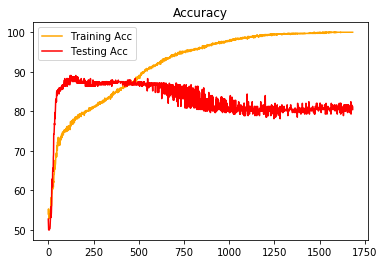

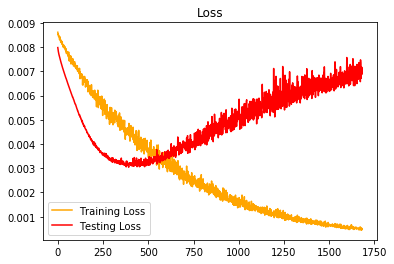

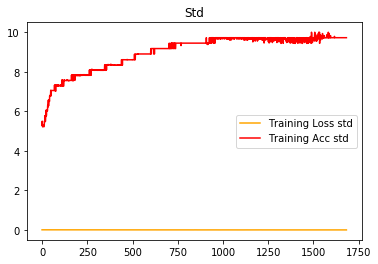

In [8]:
t1_x = []
t1_y = []
t2_x = []
t2_y = []
for i in epoch_list :
    t1_x.append(i)
    t1_y.append(accuracy_train_epoch[i])
    t2_x.append(i)
    t2_y.append(accuracy_test[i])
    
t1 = plt.plot(t1_x,t1_y , color='orange',label='Training Acc')
t2 = plt.plot(t2_x,t2_y, color= 'red',label='Validation Acc')
plt.title("Accuracy")
plt.legend(['Training Acc','Testing Acc'])
plt.show()

t1_x = []
t1_y = []
t2_x = []
t2_y = []
for i in epoch_list :
    t1_x.append(i)
    t1_y.append(loss_train_epoch[i])
    t2_x.append(i)
    t2_y.append(loss_test[i])

t1 = plt.plot(t1_x,t1_y , color='orange',label='Training Loss')
t2 = plt.plot(t2_x,t2_y, color= 'red',label='Test Loss')
plt.title("Loss")
plt.legend(['Training Loss','Testing Loss'])
plt.show()

t1_x = []
t1_y = []
t2_x = []
t2_y = []
for i in epoch_list :
    t1_x.append(i)
    t1_y.append(loss_train_std[i])
    t2_x.append(i)
    t2_y.append(accuracy_train_std[i])

t1 = plt.plot(t1_x,t1_y , color='orange',label='Training Loss std')
t2 = plt.plot(t2_x,t2_y, color= 'red',label='Training Acc std')
plt.title("Std")
plt.legend(['Training Loss std','Training Acc std'])
plt.show()



